In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("foodprices_indonesia.csv", index_col="month_year")
df

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_price
month_year,,,,,,,,,,,,,,,
1-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,5941.9752
2-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6445.0000
3-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6414.0000
4-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6083.0000
5-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,5955.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,79087.0000
9-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,68481.0000
10-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,62181.0000


In [4]:
def drop_unused_row_column(df, com_name, is_univariate=True):
    df = df[df["cm_name"].str.contains(com_name)]
    df = df.drop(columns=["adm0_id", "adm0_name", "adm1_id", "adm1_name",
                          "mkt_id", "mkt_name", "cm_id", "cur_id", "cur_name", 
                          "pt_id", "pt_name", "um_id", "um_name"], axis=1)
    if is_univariate:
        df = df.drop("cm_name", axis=1)
    
    return df

In [5]:
def split_data(data, train_all_bound, history_size, train_val_bound=None):
    data_train = []
    labels_train = []
    data_test = []
    labels_test = []
    start_train = history_size
    if train_val_bound is not None:
        data_val = []
        labels_val = []
        end_train = train_val_bound
        start_val = train_val_bound
        end_val = train_all_bound
    else:
        end_train = train_all_bound
    start_test = train_all_bound
    end_test = len(data)
    
    for i in range(start_train, end_train):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data_train.append(np.reshape(data[indices], (history_size, 1)))
        labels_train.append(data[i])
    
    if train_val_bound is not None:
        for i in range(start_val, end_val):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data_val.append(np.reshape(data[indices], (history_size, 1)))
            labels_val.append(data[i])
        
    for i in range(start_test, end_test):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data_test.append(np.reshape(data[indices], (history_size, 1)))
        labels_test.append(data[i])
    
    if train_val_bound is not None:
        return (np.array(data_train), np.array(labels_train), 
    np.array(data_val), np.array(labels_val), 
    np.array(data_test), np.array(labels_test))
    else:
        return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)

In [6]:
def create_model(unit, input_shape, kernel_regularizer=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(unit, input_shape=input_shape, kernel_regularizer=kernel_regularizer),
        tf.keras.layers.Dense(1)
    ])
    
    model.summary()
    
    return model

In [7]:
def plot_model_result(history):
    plt.figure(figsize=(10,10))
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [43]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = list(range(-plot_data[0].shape[0], 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+1)])
    plt.xlabel('Time-Step')
    return plt

## Train the forecasting model with Chili (Red) data

select only the "Chili (red)" data

In [8]:
df_chili = drop_unused_row_column(df, "red")
data = df_chili["mp_price"].values
len(data)

155

define hyperparameters

In [9]:
#hyperparameters
TRAIN_TEST_SPLIT = math.ceil(len(data) * 0.9)
VAL_SPLIT = math.ceil(TRAIN_TEST_SPLIT * 0.9)
HISTORY_SIZE = 5
BUFFER_SIZE = 1000
BATCH_SIZE = 5

UNIT_SIZE = 2
EPOCHS = 100

normalize prices

In [10]:
mean_train = data[:TRAIN_TEST_SPLIT].mean()
std_train = data[:TRAIN_TEST_SPLIT].std()
data = (data-mean_train)/std_train

split the data into train, validation, and test set

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, TRAIN_TEST_SPLIT, HISTORY_SIZE, VAL_SPLIT)
len(x_train), len(x_val), len(x_test)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test = test.batch(BATCH_SIZE).repeat()

build a forecasting model

In [20]:
chili_model = create_model(UNIT_SIZE, x_train.shape[-2:])
#chili_model.load_weights("chili.h5")
chili_model.compile(optimizer='adam', loss='mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


train with defined hyperparamters

In [21]:
history = chili_model.fit(train, epochs=EPOCHS, steps_per_epoch=len(x_train), 
                validation_data=val, validation_steps=len(x_train))

Epoch 1/100
121/121 [==============================] - 5s 38ms/step - loss: 1.0912 - val_loss: 1.7824
Epoch 2/100
121/121 [==============================] - 2s 18ms/step - loss: 0.9978 - val_loss: 1.4868
Epoch 3/100
121/121 [==============================] - 2s 14ms/step - loss: 0.8081 - val_loss: 1.2067
Epoch 4/100
121/121 [==============================] - 2s 14ms/step - loss: 0.7899 - val_loss: 0.9749
Epoch 5/100
121/121 [==============================] - 2s 15ms/step - loss: 0.6686 - val_loss: 0.8089
Epoch 6/100
121/121 [==============================] - 2s 14ms/step - loss: 0.6130 - val_loss: 0.6610
Epoch 7/100
121/121 [==============================] - 2s 20ms/step - loss: 0.5667 - val_loss: 0.5698
Epoch 8/100
121/121 [==============================] - 3s 22ms/step - loss: 0.5308 - val_loss: 0.4878
Epoch 9/100
121/121 [==============================] - 2s 17ms/step - loss: 0.4608 - val_loss: 0.4314
Epoch 10/100
121/121 [==============================] - 2s 18ms/step - loss: 0.469

121/121 [==============================] - 2s 20ms/step - loss: 0.2272 - val_loss: 0.0965
Epoch 81/100
121/121 [==============================] - 3s 21ms/step - loss: 0.2329 - val_loss: 0.1006
Epoch 82/100
121/121 [==============================] - 3s 25ms/step - loss: 0.2341 - val_loss: 0.0901
Epoch 83/100
121/121 [==============================] - 3s 26ms/step - loss: 0.2413 - val_loss: 0.0916
Epoch 84/100
121/121 [==============================] - 3s 21ms/step - loss: 0.2230 - val_loss: 0.0955
Epoch 85/100
121/121 [==============================] - 2s 14ms/step - loss: 0.2245 - val_loss: 0.0928
Epoch 86/100
121/121 [==============================] - 2s 13ms/step - loss: 0.2253 - val_loss: 0.0897
Epoch 87/100
121/121 [==============================] - 2s 21ms/step - loss: 0.2418 - val_loss: 0.0914
Epoch 88/100
121/121 [==============================] - 2s 17ms/step - loss: 0.2210 - val_loss: 0.0884
Epoch 89/100
121/121 [==============================] - 2s 15ms/step - loss: 0.2207 - 

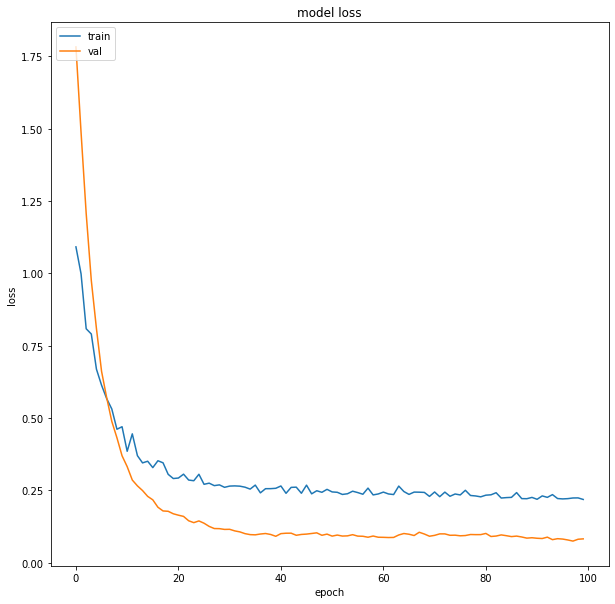

In [22]:
plot_model_result(history)

evaluate the trained model with test set

In [23]:
results = chili_model.evaluate(x_test, y_test, batch_size=5)

15/15 [==============================] - 0s 29ms/sample - loss: 0.7851


<module 'matplotlib.pyplot' from '/home/rike/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

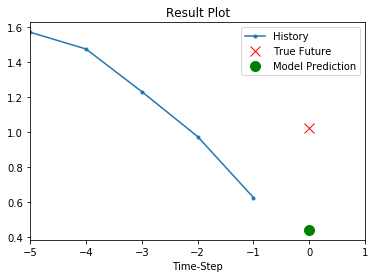

In [44]:
show_plot([x_test[0], y_test[0], chili_model.predict(np.reshape(x_test[0], (1, x_test[0].shape[0], x_test[0].shape[1])))], 0, "Result Plot")

save the trained model weights into a h5 file so it can be loaded later (no need to re-train)

In [24]:
chili_model.save_weights("chili.h5")

## Try to predict Chili (bird's eye) price using Chili (red) forecasting model

In [25]:
df_chili_bird = drop_unused_row_column(df, "bird")
#Chili (bird’s eye) - Retail
data_bird = df_chili_bird["mp_price"].values / 1000
len(data_bird)

155

In [26]:
x, y, _, _ = split_data(data, len(data_bird), HISTORY_SIZE)

# test_bird = tf.data.Dataset.from_tensor_slices((x, y))
# test_bird = test_bird.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [45]:
chili_model.evaluate(x, y, batch_size=5)

150/150 [==============================] - 0s 1ms/sample - loss: 0.2655


plot chili bird's eye predicted price and real price

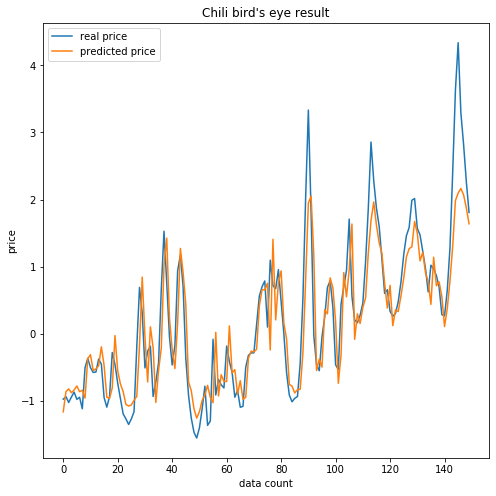

In [65]:
preds = chili_model.predict(x, batch_size=5)

plt.figure(figsize=(8,8))
plt.plot(list(range(0, y.shape[0])), y.flatten())
plt.plot(list(range(0, preds.shape[0])), preds.flatten())
plt.xlabel('data count')
plt.ylabel('price')
plt.title("Chili bird's eye result")
plt.legend(['real price', 'predicted price'], loc='upper left')
plt.show()